In [2]:
import os
import sys
import datetime as dt
import re as rere

import requests as re
import yaml
import numpy as np
import pandas as pd
from fuzzywuzzy import process
from newspaper import Article
import spacy
import en_core_web_sm

/Users/c89v/Documents/Fun/police_brutality/grassroots_law/venv/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [5]:
project_directory = 'grassroots_law'
_project_root = os.getcwd()\
    .split(project_directory)[0]\
    + project_directory + '/'
_CONFIG_FILE = _project_root + 'config.yml'
with open(_CONFIG_FILE,'r') as f:
        _cfg = yaml.safe_load(f)

sys.path.append(_project_root+'src/')

# from data.google_sheets import gs_write


def load_states():
    """
    Load dicts mapping states to abbreviations and list of counties.

    Load dicts mapping correctly spelled State names to abbreviated State
    codes (e.g. California, CA; Tennessee, TN etc) and State names to County
    names within each State.

    Returns:
        states_dict (dict): 
            {'AK': {'name': 'Alaska', 'abbreviation': 'AK'}, ...}]
        counties_dict (dict):
            {'state': {'Alabama': {'abv': 'AL', 'counties': {'county': [Autauga County, ...]}, ...}}
    """
    project_directory = 'grassroots_law'
    p_roject_root = os.getcwd()\
        .split(project_directory)[0]\
        + project_directory + '/'
    
    STATES_FILE = _project_root + 'states.yml'
    with open(STATES_FILE,'r') as f:
            states_dict = yaml.safe_load(f)

    COUNTIES_FILE = _project_root + 'states_counties.yml'
    with open(COUNTIES_FILE,'r') as f:
            counties_dict = yaml.safe_load(f)

    return states_dict, counties_dict


def load_data(from_csv=False):
    """
    Import regional police shootings CSVs from local directory

    Returns:
        df (pd.DataFrame): 
            Index:
                RangeIndex
            Columns:
                Name: 'state', dtype: object
                Name:'date', dtype: object
                Name:'victim_name', dtype: object
                Name:'officer_name', dtype: object
                Name:'armed_unarmed', dtype: object
                Name:'cause_of_death', dtype: object
                Name:'officer_charged', dtype: object
                Name:'alleged_crime', dtype: object
                Name:'county', dtype: object
                Name:'links', dtype: object
                Name:'summary' dtype: object
    """
    print(' --- Loading Data')
    if from_csv:
        df = pd.read_csv('PK Research Data - ToDate.csv', index_col=None, header=1)
    else:
        files = os.listdir('{}/data/raw'.format(_project_root))
        df = pd.DataFrame()

        usecols = _cfg['usecols']

        for f in files:
            d = pd.read_csv(
                        '{}/data/raw/{}'.format(_project_root, f),
                        header=1,
                        )
            df = df.append(
                    d,
                    ignore_index=True
                )
    df.columns = ['_'.join(c.lower().split()) for c in df.columns]
    # Drop duplicated 'summary' columns
    is_summary = list(map(lambda x: x=='summary', df.columns.values))
    if np.sum(is_summary) > 1:
        inds = [i for i,x in enumerate(n_summary) if x == True]
        to_drop = inds[1:]
        df.drop(labels=to_drop, axis=1, inplace=True)

    # Drop columns loaded as 'Unnamed'
    # 
    # As the structure of the regionalGoogle sheets varies, the API pull used 
    # to read the data did not precisely specify the range of cells to read as 
    # this is challenging when using A1 notation and ambiguous ranges. As a 
    # consequence, some empty columns are downloaded.
    to_drop = [n for n in df.columns.values if 'unnamed' in n]
    df.drop(labels=to_drop, axis=1, inplace=True) 
    
    # Where there are multiple link columns, merge into one column of URLs 
    # joined with whitespace ' '
    link_cols = [col for col in df.columns.values if 'link' in col]
    links = df[link_cols]
    links_merged = links.apply(
        lambda x: ' '.join([str(n) for n in x.values if str(n)!='nan']),
        axis=1
        )
    df['links'] = links_merged

    # Drop redundant link columns
    df.drop(labels=link_cols, axis=1, inplace=True)

    return df

def clean_col_names(df):
    print(' --- Cleaning Column Names')
    cols = []
    for c in df.columns:
        if c.startswith('alleged_crime'):
            cols.append('alleged_crime')
        elif c.startswith('victim_name'):
            cols.append('victim_name')
        elif c.startswith('officer_name'):
            cols.append('officer_name')
        elif c.startswith('victim_armed'):
            cols.append('armed_unarmed')
        else:
            cols.append(c)
    df.columns = cols
    return df

def clean_states(df, states_dict):
    """
    Use fuzzy string matching to map state entries to standard long-form and 
    abbreviated state names.
    
    Args:
        df (pd.DataFrame): Merged data from the police shootings page
        
        states_dict (dict): dictionary mapping abbreviated state names to 
        long-form state names and abbreviated state names.
        e.g.: state_dict['AK'] = {'name': 'Alaska', 'abbreviation': 'AK'}

    Returns:
        df (pd.DataFrame): Updated version of input df with 'state' and 
        'state_code' columns containing the long-form and abbreviated state 
        name.
    """
    def correct_state(x):
        """
        Return standardized long-form or abbreviated state name depending on 
        input

        Args:
            x (str): State name from raw data

        Returns:
            str: Closest matching state name or abbreviation (fuzzy match)
        """
        x=str(x).capitalize()
        
        if x.lower() == 'nan':
            return 'nan'
        
        if x == '':
            return x

        if len(x.strip()) == 2:
            if x in states_short:
                return x.strip()
            else:
                match = process.extractOne(x.strip(), states_short)
                if match[1] > 75:
                    return match[0]
                else:
                    return '?' + x
        else:
            if x in states_long:
                return x
            elif all(['washington' in x.lower(), 'd' in x.lower(), 'c' in x.lower()]):
                return 'District of Columbia'
            else:
                match = process.extractOne(x.strip(), states_long)
                if match[1] > 75:
                    return match[0]
                else:
                    return '?' + x


    def return_long(x):
        """
        Return long-form state name. As data were entered variously in 
        long-form or abbreviated form by different users, the corrected state 
        list is a mix of forms.

        Args:
            x (str): Corrected state name or abbreviation

        Returns:
            str: Long form state name, or 'nan' if state could not be 
            identified
        """
        for state in long_short:
            if x in state:
                return state[0]
        return 'nan'


    def return_short(x):
        """
        Return abbreviated state name. As data were entered variously in 
        long-form or abbreviated form by different users, the corrected state 
        list is a mix of forms.

        Args:
            x (str): Corrected state name or abbreviation

        Returns:
            str: Abbreviated state name, or 'nan' if state could not be 
            identified
        """
        for state in long_short:
            if x in state:
                return state[1]
        return 'nan'

    print(' --- Cleaning State Data')
    states_long = [
        states_dict[key]['name'] for key in states_dict.keys()
        ]

    states_short = [
        states_dict[key]['abbreviation'] for key in states_dict.keys()
        ]

    long_short = [
        [
            states_dict[key]['name'], 
            states_dict[key]['abbreviation']
            ] \
        for key in states_dict.keys()
    ]

    df['state'] = list(map(correct_state, df['state'])) 
    df.insert(1, 'state_code', df['state'])

    df['state'] = list(map(return_long, df['state']))
    df['state_code'] = list(map(return_short, df['state_code']))

    return df


def clean_counties(df, counties_dict):
    
    def correct_county(x):
        """
        Return fuzzy-matched county name from dict of counties within a state,
        or prepent county with '?' if ambiguous.

        Args:
            x (tuple): (state_name (clean, long form), county)
        
        Returns:
            (str): Correctly spelled and formatted county name, or input 
            prepended with '?' if ambiguous
        """
        
        state = x[0]
        county = str(x[1]).strip().lower().capitalize()
        
        if county == 'Nan':
            return 'nan'
        if state.lower() == 'nan':
            return '?' + county
        if state.lower() == 'district of columbia':
            return 'nan'

        try:
            counties = counties_dict['state'][state]['counties']['county']
            match = process.extractOne(county, counties)
            if match[1] < 75:
                return '?' + county
            else:
                return match[0][:-7] # Do not include the word 'county'

        except KeyError:
            print(f'Missing county entry: State: {state} County: {county}')

    print(' --- Cleaning County Data')
    state_county = [tuple(x) for x in df.loc[:,['state', 'county']].to_numpy()]
    df['county'] = list(map(correct_county, state_county))

    return df


def dates_to_datetime(df):
    """
    Convert type of date values to np.datetime64
    """
    def dt_or_nat(x):
        try:
            x = pd.to_datetime(x)
            return x
        except:
            return np.datetime64('NaT')


def scrape_links(df):
    """
    Scrape URLs associated with each incident to confirm location details and
    extract other keywords.

    Args:
        df (pd.DataFrame): Merged police shootings DataFrame
    """
    nlp = en_core_web_sm.load()
    # Entity types to add to keywords
    ents = ['GPE','PERSON','ORG','LOC']
    
    keywords = []
    for articles in df.links:
        urls = articles.split(' ')
        kwords = set()
        for url in urls:
            
            if 'http' in url: # skip invalid entries
                try:    
                    article = Article(url)
                    article.download()
                    article.parse()
                    article.nlp()
                    doc = nlp(article.text)
                    kwords.update(
                        [
                            X.text for X in doc.ents if X.label_ in ents
                            ]
                        )
                except:
                    pass
            
        keywords.append(sorted(list(kwords)))
    df['keywords'] = keywords
    return df

In [196]:
states_dict, counties_dict = load_states()
data = load_data(from_csv=True)

import datetime as dt

def clean_dates(df):
    '''
    Convert excel formatted serial dates to python datetime
    '''
    def convert_xldates(date):
        try:
            date = int(date)
            temp = dt.datetime(1900, 1, 1)
            delta = dt.timedelta(days=int(date))
            return temp + delta
        except ValueError: # nan
            return 'nan'
        except OverflowError: # integers that are too high
            return 'nan'
    print(' --- Cleaning Dates')
    df['date'] = df['date'].apply(convert_xldates)
    return df

data = clean_dates(data)

 --- Loading Data
 --- Cleaning Dates


In [197]:
def cols_to_str(df, str_cols):
    '''
    Find all columns in a dataframe that are object dtype and convert to string format. 
    '''
    print(' --- Converting {0} columns to strings'.format(str_cols))
    df[str_cols] = df[str_cols].astype(str)
    return df

str_cols = ['victim_armed', 'officer_charged']
data = cols_to_str(data, str_cols = str_cols)

 --- Converting ['victim_armed', 'officer_charged'] columns to strings


In [198]:
def clean_col(df, col_to_clean):
    """
    Function to clean text to keep only letters and remove stopwords
    Returns a string of the cleaned text and a new column in dataframe called clean_<col_to_clean>
    """
    def clean_text(raw_text):
        letters_only = rere.sub('[^a-zA-Z]', ' ', raw_text)
        words = letters_only.lower().split()
        # Combine words into a paragraph again
        useful_words_string = ' '.join(words)
        return(useful_words_string)
    
    print(' --- Cleaning {0} column'.format(col_to_clean))
    df[f'clean_{col_to_clean}'] = df[f'{col_to_clean}'].apply(clean_text)
    return df

data = clean_col(data, 'victim_armed')
data.head()

 --- Cleaning victim_armed column


,timestamp,state,date,"victim_name_(if_not_listed,_enter_unknown)","officer_name_(if_not_listed,_enter_unknown)",police_department,victim_armed,cause_of_death,officer_charged,alleged_crime/reason_for_police_presence,county,summary,your_name,email_address,links,clean_victim_armed
0,NaN,Connecticut,2020-01-18 00:00:00,Mubarak Soulemane,Brian North (Joshua Jackson & Ross Dalling at ...,NaN,Knife,Gunshot & tasered,Under investigation,Carjacked a rideshare driver and engaged offic...,West Haven,"Teen, known to local police to be battliing wi...",NaN,NaN,https://www.courant.com/breaking-news/hc-br-mu...,knife
1,NaN,Connecticut,2020-01-04 00:00:00,Michael Gregory,"Christopher Flynn, Brendon Nelson, Wojciech Po...",NaN,yes (knife),gunshot,no,Violated a no-contact protective order after h...,Ansonia,His girlfriend went to the police station as h...,NaN,NaN,https://www.nbcconnecticut.com/news/local/poli...,yes knife
2,NaN,Connecticut,2020-01-18 00:00:00,Murbarak Soulemane,Brian North,NaN,knife,gunshot,no,stolen vehicle,NaN,Suspect had altercation inside ATT store and w...,NaN,NaN,https://www.fox61.com/article/news/state-polic...,knife
3,NaN,Connecticut,2020-04-04 00:00:00,Jose Soto,"Sgt. Shawn Krom (Manchester PD), David William...",NaN,No,Gunshot,No,Violation of parole,Manchester,Police officers went to Soto's house to take h...,NaN,NaN,https://www.nbcconnecticut.com/news/local/offi...,no
4,NaN,Connecticut,2020-01-22 00:00:00,Edward Gendron,Waterbury Officer Ronald W. Tompkins III,NaN,Yes (gun),Gunshot,No,None; it was during a welfare check,New Haven,Officers were called to a duplex home at 81 Cr...,NaN,NaN,https://www.courant.com/breaking-news/hc-br-vi...,yes gun


In [189]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# choose a color palette 
current_palette = sns.color_palette('Paired')

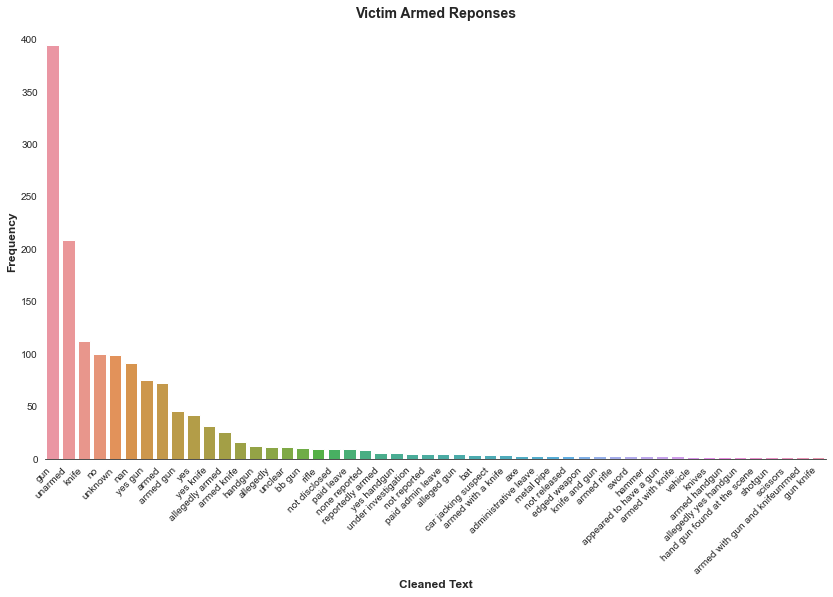

In [192]:
# Set initial plot options
sns.set_style('white')
plt.figure(figsize = (14, 8))

# Create a countplot
chart = sns.countplot(x = 'clean_victim_armed'
                      , data = data
                      , order = data['clean_victim_armed'].value_counts().iloc[:50].index
                 )

# Despine visualizations
sns.despine(left = True)

# Final styling touche
plt.ylabel('Frequency', fontsize = 12, fontweight = 'semibold')
plt.xlabel('Cleaned Text', fontsize = 12, fontweight = 'semibold')

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Victim Armed Reponses', fontsize = 14, fontweight = 'semibold')

plt.show()

In [ ]:
def armed_categorizer(df):
    """
    Takes the clean_victim_armed column and categorizes the values into 4 categories:
    1. deadly-weapon
    2. non-deadly-weapon
    3. unknown
    4. unarmed
    """
        
    def pattern_finder(col): 
        """
        First step in narrowing down if the victim was unarmed, armed with a deadly weapon,
        armed with a non-deadly weapon, or if the status is unknown/alleged/unclear, etc.
        This function narrows down the unknown or unarmed statuses and passes the complete text back otherwise. 
        """
        armed_result = rere.findall(r'armed|gun|revolver|caliber|yes|rifle|pipe|knife|fire|weapon|hammer|knives|sword|weapon|taser|scissor', col)
        unknown_result = rere.findall(r'|unknown|allegedly|potential|according|nan|unclear|bat|not |claim|reportedly', col)
        unarmed_result = rere.findall(r'no|unarmed', col)
        if armed_result and (not unknown_result or not unarmed_result):
            return col
        elif unarmed_result:
            return 'unarmed'
        else:
            return 'unknown'

    def weapon_type_1(col):
        """
        Second step to categorize more entries as unknown - if the gun is alleged then it should default to unknown.
        Find patterns of non-deadly weapons and return those to the armed-non-deadly category.
        Find patterns in descriptions of why to question the validity of the armed status and pass to unknown category. 
        """
        non_deadly = rere.findall(r'bb|fake|toy|plastic|airsoft|soft|pellet|play|taser|replica|rebar|taser|scissor|stun', col)
        unknown_result = rere.findall(r'unknown|dispute|untrue|alleg|maybe|possibl|unsure|conflict|potential|presum|according|unconfirmed|unclear|bat|not|claim|reportedly', col)
        if non_deadly:
            return 'non-deadly-weapon'
        elif unknown_result:
            return 'unknown'
        else:
            return col

    def weapon_type_2(col):
        """
        At this point, we can classify the remaining results into the armed-deadly category. 
        Edge cases can be QA'd by volunteers. 
        """
        non_deadly = rere.findall(r'unarmed|unknown|non-deadly-weapon', col)
        if non_deadly:
            return col
        else:
            return 'deadly-weapon'

    print(' --- Creating Victim Armed Categories: clean_victim_armed')
    df['clean_victim_armed'] = df['clean_victim_armed'].apply(pattern_finder)
    df['clean_victim_armed'] = df['clean_victim_armed'].apply(weapon_type_1)
    df['clean_victim_armed'] = df['clean_victim_armed'].apply(weapon_type_2)
    return df


data = armed_categorizer(data)

In [200]:
data['clean_victim_armed'].value_counts()

deadly-weapon        939
unarmed              473
unknown              296
non-deadly-weapon     48
Name: clean_victim_armed, dtype: int64

In [220]:
df_plot = data[['state', 'clean_victim_armed']]
df_pivot = df_plot.pivot_table(index='state', columns='clean_victim_armed', values = 'state', aggfunc=len, fill_value=0)
df_pivot

clean_victim_armed,deadly-weapon,non-deadly-weapon,unarmed,unknown
state,,,,
AK,0,0,6,3
Alabama,13,0,4,0
Alabama,1,0,0,0
Alaska,14,0,5,2
Arizona,25,0,14,1
...,...,...,...,...
West Virginia,1,0,0,0
Wisconsin,25,0,10,3
Wisconsin,0,0,0,2


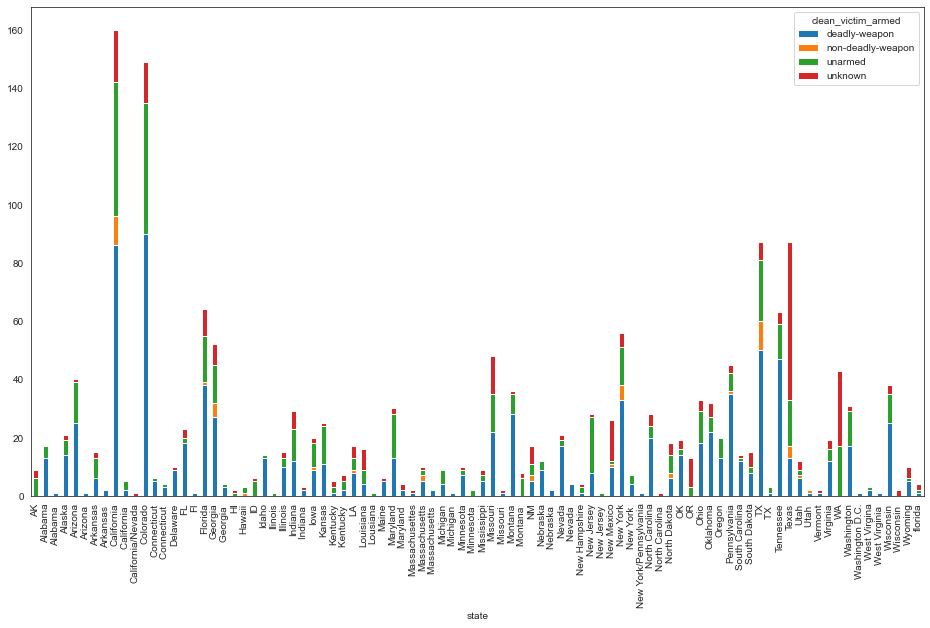

In [226]:
df_pivot.plot.bar(stacked=True, figsize=(16,9))
plt.show()